## Assignment 3: Improving the Pipeline
## by Lilian Huang

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing, svm, tree, decomposition
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from scipy import optimize
import time
import seaborn as sns
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import pipeline_library_updated as pl
%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Part 1: Data Exploration and Wrangling

First we read in the data and carry out basic exploration such as counting the number of null values.

In [2]:
df = pl.read_data('projects_2012_2013.csv')

In [3]:
df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,4/14/13,5/2/13
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,...,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,t,4/7/12,4/18/12
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,...,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,f,1/30/12,4/15/12
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,...,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,f,10/11/12,12/5/12
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,...,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,f,1/8/13,3/25/13


In [4]:
pl.info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124976 entries, 0 to 124975
Data columns (total 26 columns):
projectid                                 124976 non-null object
teacher_acctid                            124976 non-null object
schoolid                                  124976 non-null object
school_ncesid                             115743 non-null float64
school_latitude                           124976 non-null float64
school_longitude                          124976 non-null float64
school_city                               124976 non-null object
school_state                              124976 non-null object
school_metro                              109752 non-null object
school_district                           124804 non-null object
school_county                             124976 non-null object
school_charter                            124976 non-null object
school_magnet                             124976 non-null object
teacher_prefix                           

In [5]:
pl.null_count(df)

projectid                                     0
teacher_acctid                                0
schoolid                                      0
school_ncesid                              9233
school_latitude                               0
school_longitude                              0
school_city                                   0
school_state                                  0
school_metro                              15224
school_district                             172
school_county                                 0
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                             

We see that there are some boolean columns which are coded as "t" and "f" instead of 1 and 0, so we recode them and confirm that this was successful.

In [6]:
for colname in ['school_charter', 'school_magnet', 'eligible_double_your_impact_match']:
    pl.recode_booleans(df, colname, 't', 'f')

In [7]:
df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,0,4/14/13,5/2/13
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,...,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,1,4/7/12,4/18/12
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,...,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,0,1/30/12,4/15/12
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,...,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,0,10/11/12,12/5/12
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,...,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,0,1/8/13,3/25/13


We now look at summary statistics for the numeric columns.

In [8]:
pl.summ_stats(df)

,school_ncesid,school_latitude,school_longitude,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match
count,1.157430e+05,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124917.000000,124976.000000
mean,2.448448e+11,36.827284,-95.859299,0.093106,0.085640,654.011811,95.445760,0.296769
std,1.644728e+11,4.963669,18.392876,0.290582,0.279833,1098.015854,163.481912,0.456836
min,1.000050e+10,18.249140,-171.690554,0.000000,0.000000,92.000000,1.000000,0.000000
25%,6.344101e+10,33.872504,-117.806418,0.000000,0.000000,345.810000,23.000000,0.000000
50%,2.200870e+11,36.617410,-90.101563,0.000000,0.000000,510.500000,30.000000,0.000000
75%,3.704880e+11,40.676156,-80.713740,0.000000,0.000000,752.960000,100.000000,1.000000
max,6.100010e+11,65.672562,-66.628036,1.000000,1.000000,164382.840000,12143.000000,1.000000


We also have to create our desired outcome variable - whether a project will not get fully funded within 60 days of posting.

In [9]:
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['datefullyfunded'] = pd.to_datetime(df['datefullyfunded'])

In [10]:
df['days_to_funded'] = (df['datefullyfunded'] - df['date_posted']).dt.days

In [11]:
df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,days_to_funded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,0,2013-04-14,2013-05-02,18
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,...,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,1,2012-04-07,2012-04-18,11
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,...,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,0,2012-01-30,2012-04-15,76
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,...,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,0,2012-10-11,2012-12-05,55
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,...,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,0,2013-01-08,2013-03-25,76


In [12]:
df['fundedin60'] = np.where(df['days_to_funded'] > 60, 1, 0)

In [13]:
df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,days_to_funded,fundedin60
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,0,2013-04-14,2013-05-02,18,0
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,...,Books,highest poverty,Grades 3-5,282.47,28.0,1,2012-04-07,2012-04-18,11,0
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,...,Technology,high poverty,Grades 3-5,1012.38,56.0,0,2012-01-30,2012-04-15,76,1
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,...,Books,high poverty,Grades PreK-2,175.33,23.0,0,2012-10-11,2012-12-05,55,0
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,...,Technology,high poverty,Grades PreK-2,3591.11,150.0,0,2013-01-08,2013-03-25,76,1


We see that 28.8% of the observations have a label of 1, i.e. they were not fully funded in 60 days.

In [14]:
pl.make_percent_table(df, "fundedin60")

,fundedin60,count,percent
0,0,88966,71.186468
1,1,36010,28.813532


We then carry out more data exploration by producing histograms of each numeric variable, and tables counting the values of each categorical variable.

We see that, for example, 50% of the proposed projects are for urban schools, and 38% serve pre-K to 2nd grade students. the most popular types of resources requested are technology and supplies. 

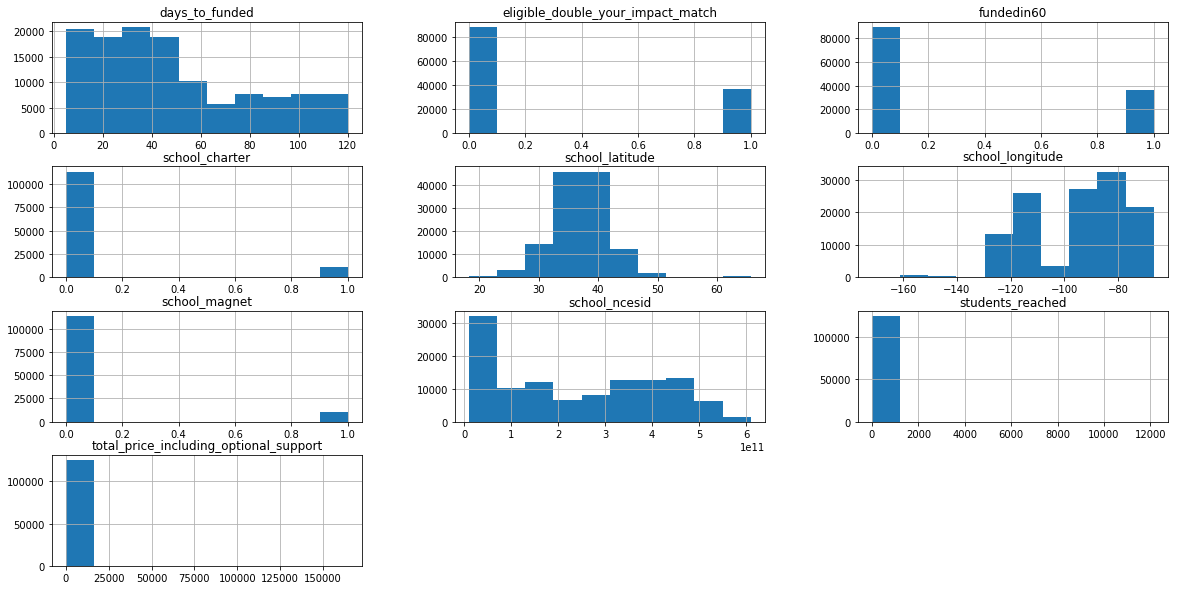

In [15]:
pl.make_hist(df, 20, 10)

In [16]:
table = pl.make_percent_table(df, "school_metro")
table.sort_values(by="percent", ascending=False)

,school_metro,count,percent
2,urban,62267,49.823166
1,suburban,33084,26.472283
0,rural,14401,11.523012


In [17]:
table = pl.make_percent_table(df, "teacher_prefix")
table.sort_values(by="percent", ascending=False)

,teacher_prefix,count,percent
2,Mrs.,60190,48.161247
3,Ms.,48511,38.816253
1,Mr.,16273,13.020900
0,Dr.,2,0.001600


In [18]:
table = pl.make_percent_table(df, "primary_focus_subject")
table.sort_values(by="percent", ascending=False)

,primary_focus_subject,count,percent
15,Literacy,37408,29.932147
17,Mathematics,16859,13.489790
16,Literature & Writing,16141,12.915280
24,Special Needs,8348,6.679682
26,Visual Arts,5870,4.696902
0,Applied Sciences,5825,4.660895
8,Environmental Science,4835,3.868743
12,Health & Life Science,4185,3.348643
18,Music,3931,3.145404
14,History & Geography,2701,2.161215


In [19]:
table = pl.make_percent_table(df, "primary_focus_area")
table.sort_values(by="percent", ascending=False)

,primary_focus_area,count,percent
3,Literacy & Language,56051,44.849411
4,Math & Science,31704,25.368071
5,Music & The Arts,11483,9.188164
0,Applied Learning,8722,6.978940
6,Special Needs,8348,6.679682
2,History & Civics,5158,4.127192
1,Health & Sports,3495,2.796537


In [20]:
table = pl.make_percent_table(df, "secondary_focus_subject")
table.sort_values(by="percent", ascending=False)

,secondary_focus_subject,count,percent
15,Literacy,12598,10.080335
17,Mathematics,12513,10.012322
16,Literature & Writing,12389,9.913103
24,Special Needs,5217,4.174401
5,ESL,4698,3.759122
6,Early Development,3599,2.879753
0,Applied Sciences,3380,2.704519
12,Health & Life Science,3103,2.482877
8,Environmental Science,2997,2.398060
14,History & Geography,2918,2.334848


In [21]:
table = pl.make_percent_table(df, "secondary_focus_area")
table.sort_values(by="percent", ascending=False)

,secondary_focus_area,count,percent
3,Literacy & Language,30056,24.049417
4,Math & Science,21993,17.597779
0,Applied Learning,11562,9.251376
2,History & Civics,6781,5.425842
5,Music & The Arts,5803,4.643292
6,Special Needs,5217,4.174401
1,Health & Sports,3008,2.406862


In [22]:
table = pl.make_percent_table(df, "resource_type")
table.sort_values(by="percent", ascending=False)

,resource_type,count,percent
3,Technology,45886,36.715849
2,Supplies,40270,32.222187
0,Books,24226,19.384522
1,Other,13732,10.987710
4,Trips,702,0.561708
5,Visitors,143,0.114422


In [23]:
table = pl.make_percent_table(df, "poverty_level")
table.sort_values(by="percent", ascending=False)

,poverty_level,count,percent
1,highest poverty,67752,54.212009
0,high poverty,34361,27.494079
3,moderate poverty,19066,15.255729
2,low poverty,3797,3.038183


In [24]:
table = pl.make_percent_table(df, "grade_level")
table.sort_values(by="percent", ascending=False)

,grade_level,count,percent
3,Grades PreK-2,47730,38.191333
0,Grades 3-5,39242,31.399629
1,Grades 6-8,21479,17.186500
2,Grades 9-12,16522,13.220138


We produce a heatmap of correlations between variables, but no correlations stand out as being especially noteworthy. The outcome variable (not being funded within 60 days of posting) is highly correlated with the days to the project being funded, but this is obvious by construction.

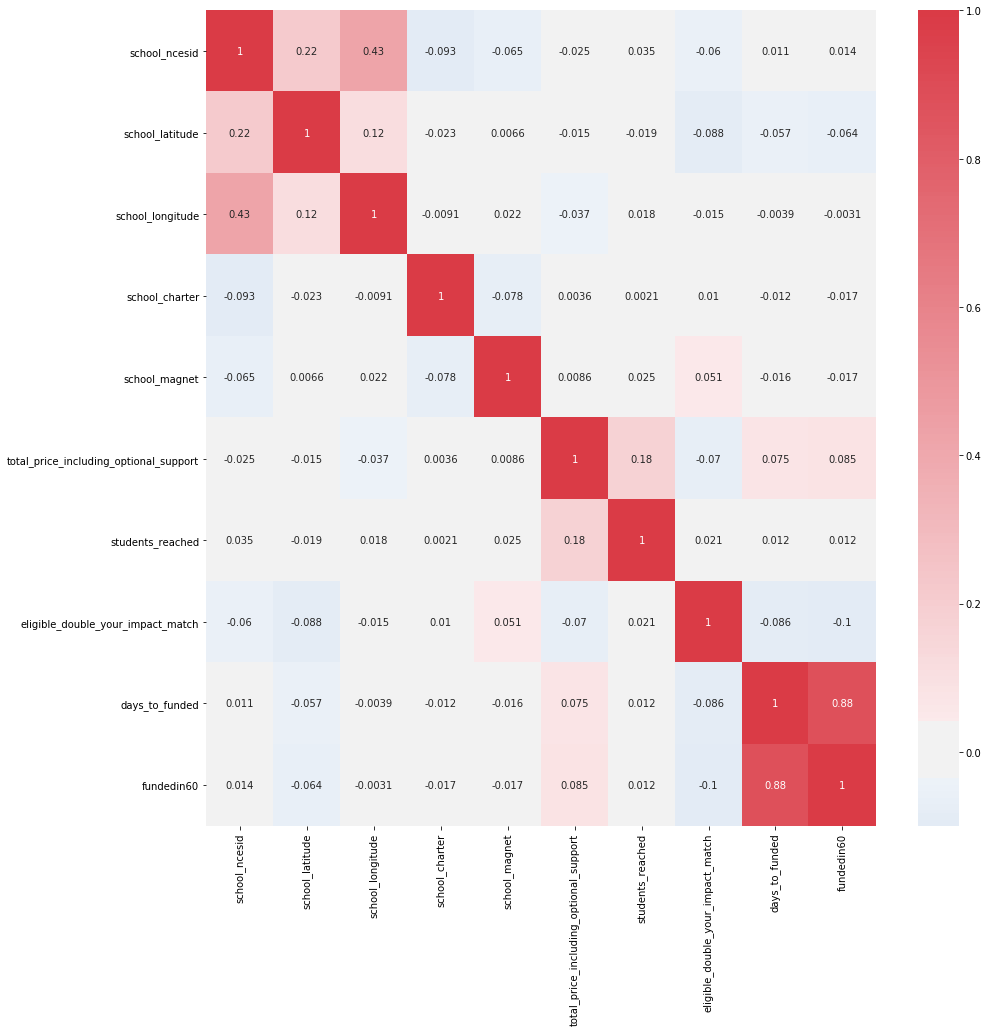

In [25]:
pl.corr_heatmap(df, 15, 15)

We also produce boxplots of some variables.

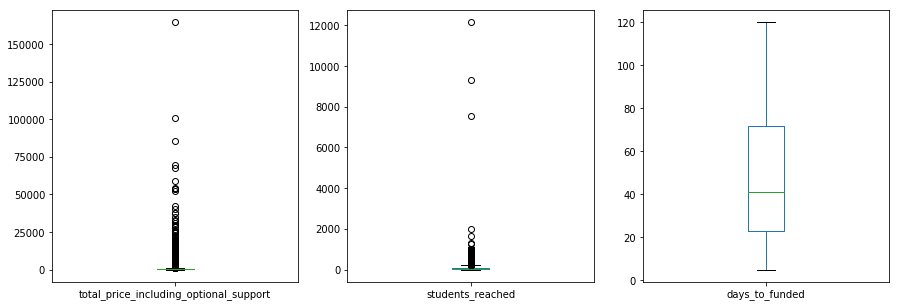

In [26]:
pl.make_box(df[['total_price_including_optional_support', 'students_reached', 'days_to_funded']], 15, 5)

We then fill in null values in the dataframe. For numeric variables, we use the median of that column, while for non-numeric variables, we use the value that occurs most frequently in that column. With more domain knowledge, it would be possible to carry out more fine-grained imputation of missing variables.

In [27]:
df = pl.impute_median(df)

In [28]:
pl.null_count(df)

projectid                                     0
teacher_acctid                                0
schoolid                                      0
school_ncesid                                 0
school_latitude                               0
school_longitude                              0
school_city                                   0
school_state                                  0
school_metro                              15224
school_district                             172
school_county                                 0
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                             

In [29]:
df = df.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [30]:
pl.null_count(df)

projectid                                 0
teacher_acctid                            0
schoolid                                  0
school_ncesid                             0
school_latitude                           0
school_longitude                          0
school_city                               0
school_state                              0
school_metro                              0
school_district                           0
school_county                             0
school_charter                            0
school_magnet                             0
teacher_prefix                            0
primary_focus_subject                     0
primary_focus_area                        0
secondary_focus_subject                   0
secondary_focus_area                      0
resource_type                             0
poverty_level                             0
grade_level                               0
total_price_including_optional_support    0
students_reached                

### Part 2: Generating Features

We now generate dummy variables from the categorical variables, and drop the original variables that have now been converted to dummies.
We also drop ID variables, and geographical variables, which are too granular to contribute to the model.

In [31]:
for colname in ['school_metro', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 
                'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level']:
    df[colname] = df[colname].astype('category')

In [32]:
df.dtypes

projectid                                         object
teacher_acctid                                    object
schoolid                                          object
school_ncesid                                    float64
school_latitude                                  float64
school_longitude                                 float64
school_city                                       object
school_state                                      object
school_metro                                    category
school_district                                   object
school_county                                     object
school_charter                                     int64
school_magnet                                      int64
teacher_prefix                                  category
primary_focus_subject                           category
primary_focus_area                              category
secondary_focus_subject                         category
secondary_focus_area           

In [33]:
for colname in ['school_metro', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 
                'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level']:
    df = pl.make_dummies(df, colname)

In [34]:
df.dtypes

projectid                                               object
teacher_acctid                                          object
schoolid                                                object
school_ncesid                                          float64
school_latitude                                        float64
school_longitude                                       float64
school_city                                             object
school_state                                            object
school_metro                                          category
school_district                                         object
school_county                                           object
school_charter                                           int64
school_magnet                                            int64
teacher_prefix                                        category
primary_focus_subject                                 category
primary_focus_area                                    c

In [35]:
df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,1,0,0,0,1,0,0,0,0,1
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,...,0,0,0,0,1,0,0,0,0,0
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,...,0,1,0,0,0,0,0,0,0,0
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,...,0,0,0,0,0,0,0,0,0,1
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,...,0,1,0,0,0,0,0,0,0,1


In [36]:
reduced_df = df.drop(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid', 
                      'school_latitude', 'school_longitude', 'school_city', 'school_state', 
                      'school_district', 'school_county'], axis = 1)

In [37]:
reduced_df = reduced_df.drop(['school_metro', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 
                'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level'], axis = 1)

In [38]:
reduced_df.dtypes

school_charter                                           int64
school_magnet                                            int64
total_price_including_optional_support                 float64
students_reached                                       float64
eligible_double_your_impact_match                        int64
date_posted                                     datetime64[ns]
datefullyfunded                                 datetime64[ns]
days_to_funded                                           int64
fundedin60                                               int64
school_metro_suburban                                    uint8
school_metro_urban                                       uint8
teacher_prefix_Mr.                                       uint8
teacher_prefix_Mrs.                                      uint8
teacher_prefix_Ms.                                       uint8
primary_focus_subject_Character Education                uint8
primary_focus_subject_Civics & Government              

We also bin the continuous variables "students_reached" and "total_price_including_optional_support" into discrete categories, using percentiles since these have a large range. We then drop the original continuous variables.

In [39]:
student_bins = pl.get_thresholds(reduced_df, "students_reached")
student_bins

[1.0, 21.0, 26.0, 50.0, 120.0, 12143.0]

In [40]:
reduced_df, bins = pl.discretize(reduced_df, "students_reached", bins=student_bins)

In [41]:
reduced_df[["students_reached", "students_reached_discrete"]].head(n=50)

,students_reached,students_reached_discrete
0,31.0,2
1,28.0,2
2,56.0,3
3,23.0,1
4,150.0,4
5,15.0,0
6,37.0,2
7,30.0,2
8,25.0,1
9,24.0,1


In [42]:
price_bins = pl.get_thresholds(reduced_df, "total_price_including_optional_support")
price_bins

[92.0, 304.45, 451.07, 562.71, 837.51, 164382.84]

In [43]:
reduced_df, bins = pl.discretize(reduced_df, "total_price_including_optional_support", bins=price_bins)

In [44]:
reduced_df[["total_price_including_optional_support", "total_price_including_optional_support_discrete"]].head(n=50)

,total_price_including_optional_support,total_price_including_optional_support_discrete
0,1498.61,4
1,282.47,0
2,1012.38,4
3,175.33,0
4,3591.11,4
5,475.85,2
6,390.65,1
7,3877.20,4
8,838.75,4
9,1477.44,4


In [45]:
reduced_df = reduced_df.drop(["students_reached", "total_price_including_optional_support"], axis = 1)

With all desired features present, we look again at the dataframe.

In [46]:
pl.info(reduced_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124976 entries, 0 to 124975
Data columns (total 89 columns):
school_charter                                     124976 non-null int64
school_magnet                                      124976 non-null int64
eligible_double_your_impact_match                  124976 non-null int64
date_posted                                        124976 non-null datetime64[ns]
datefullyfunded                                    124976 non-null datetime64[ns]
days_to_funded                                     124976 non-null int64
fundedin60                                         124976 non-null int64
school_metro_suburban                              124976 non-null uint8
school_metro_urban                                 124976 non-null uint8
teacher_prefix_Mr.                                 124976 non-null uint8
teacher_prefix_Mrs.                                124976 non-null uint8
teacher_prefix_Ms.                                 124976 non-null u

In [47]:
pl.summ_stats(reduced_df)

,school_charter,school_magnet,eligible_double_your_impact_match,days_to_funded,fundedin60,school_metro_suburban,school_metro_urban,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,...,resource_type_Trips,resource_type_Visitors,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,students_reached_discrete,total_price_including_optional_support_discrete
count,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,...,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000,124976.000000
mean,0.093106,0.085640,0.296769,48.349947,0.288135,0.264723,0.620047,0.130209,0.481612,0.388163,...,0.005617,0.001144,0.542120,0.030382,0.152557,0.171865,0.132201,0.381937,1.958144,1.998952
std,0.290582,0.279833,0.456836,31.998024,0.452896,0.441187,0.485377,0.336535,0.499664,0.487334,...,0.074737,0.033807,0.498225,0.171636,0.359562,0.377265,0.338711,0.485863,1.401745,1.413169
min,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,0.000000,41.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000
75%,0.000000,0.000000,1.000000,72.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,3.000000
max,1.000000,1.000000,1.000000,120.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000


We also produce layered histograms to compare how the distribution of every independent variable differs between the dependent variable's classes.

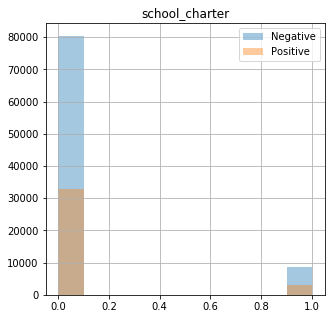

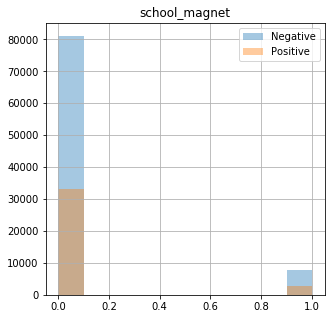

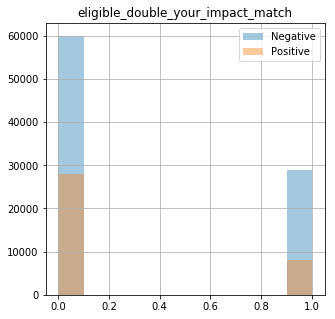

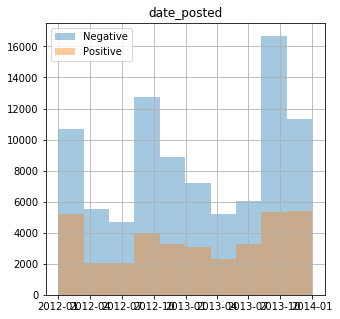

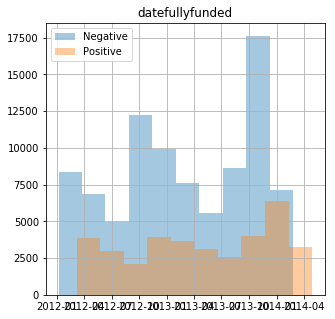

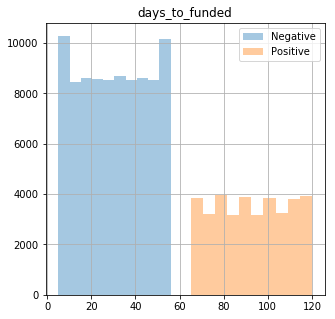

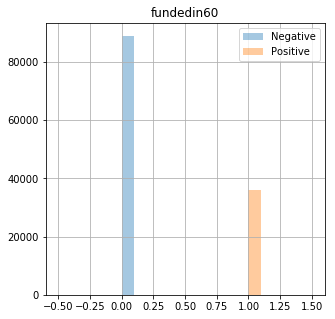

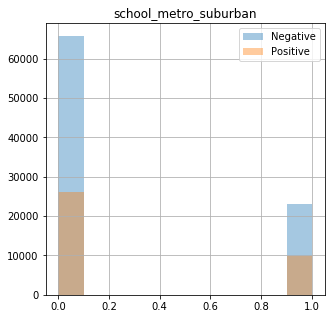

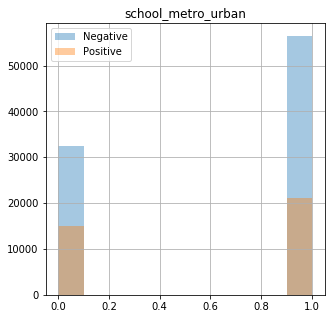

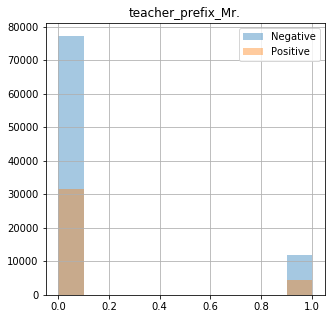

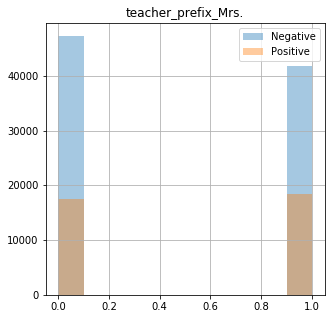

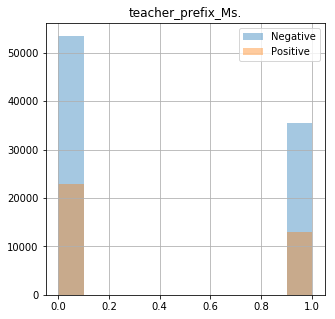

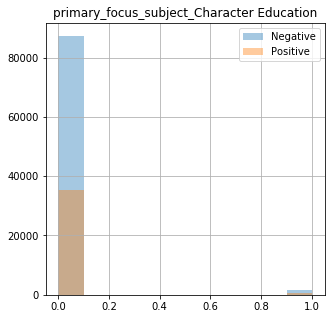

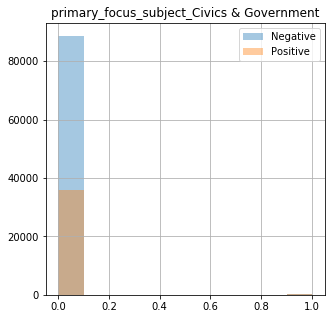

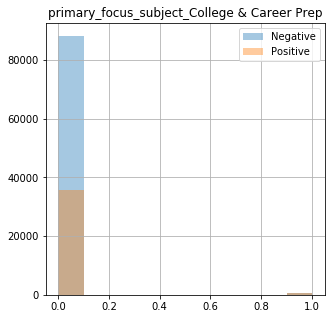

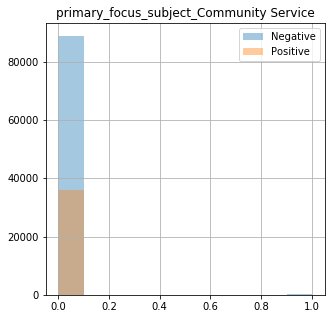

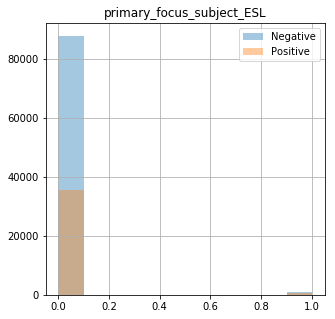

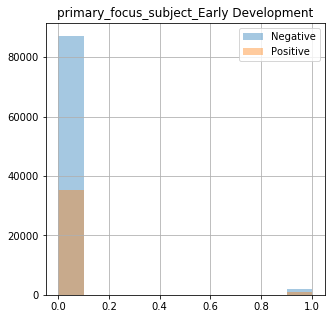

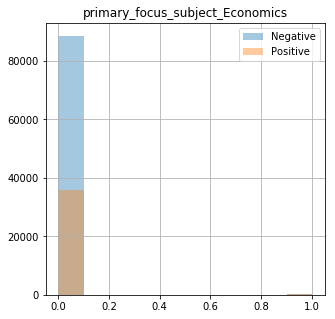

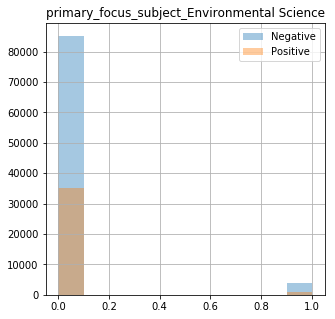

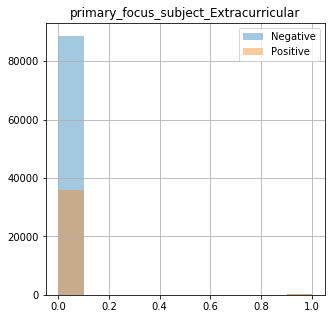

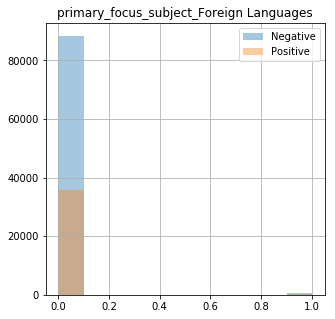

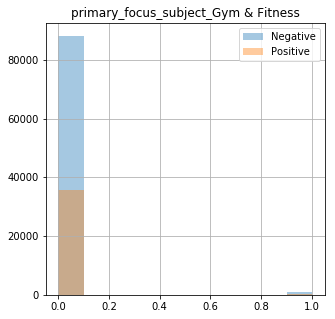

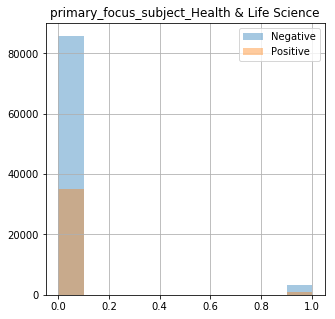

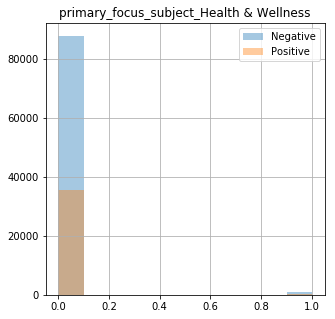

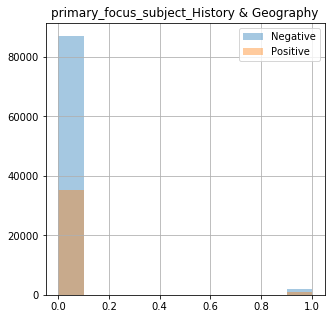

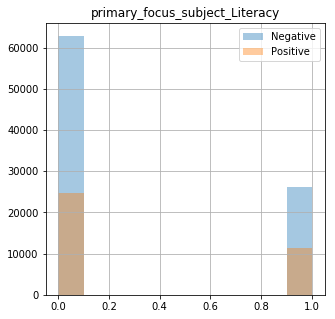

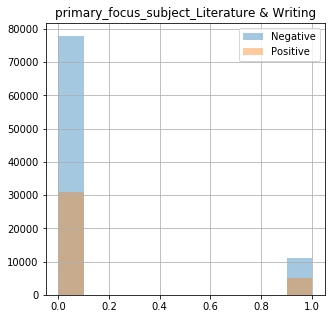

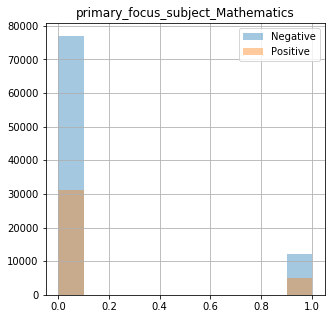

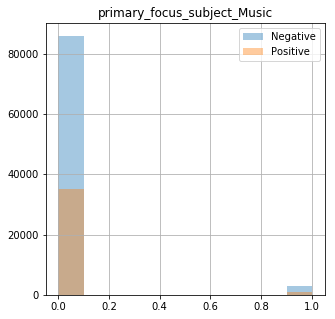

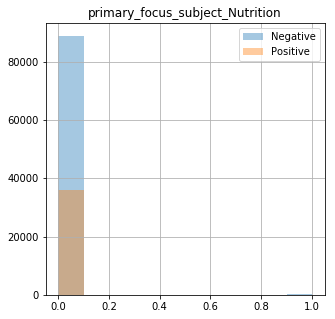

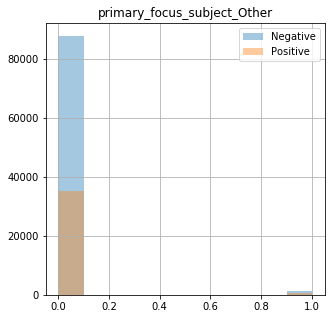

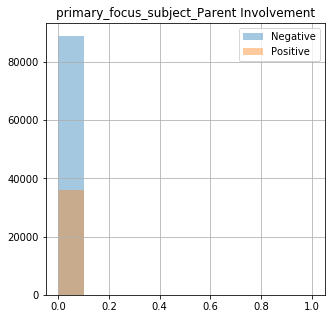

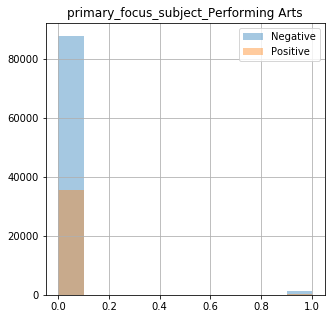

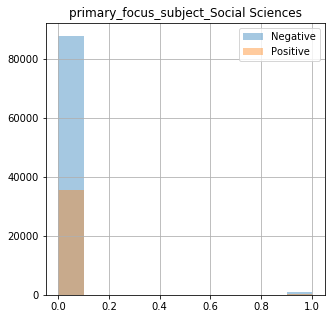

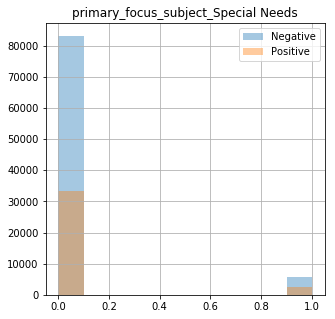

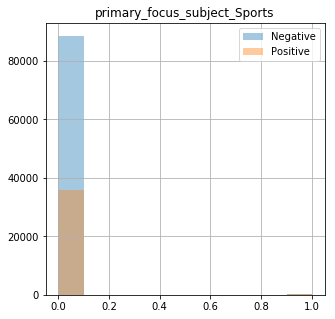

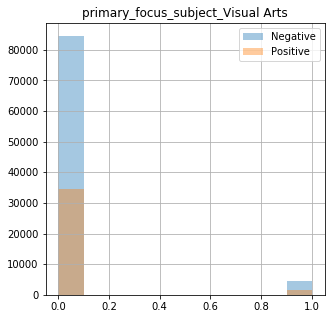

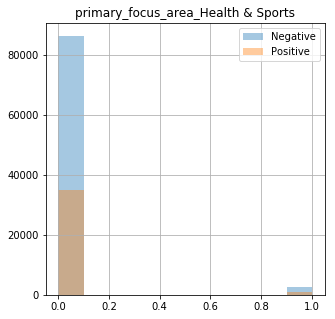

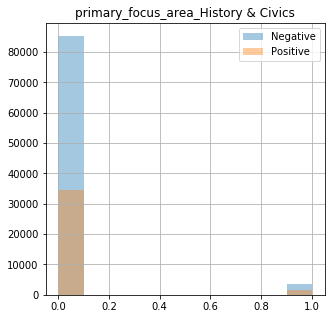

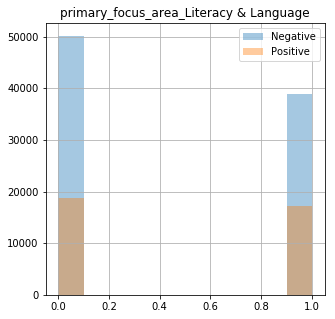

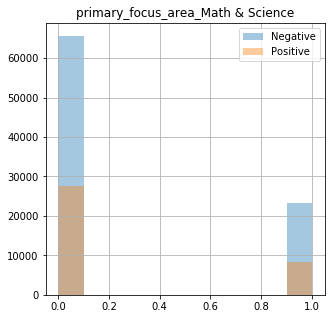

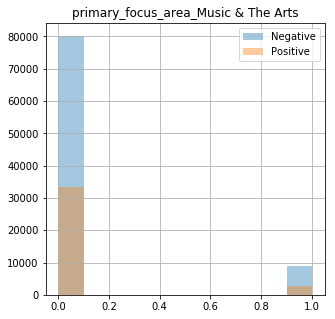

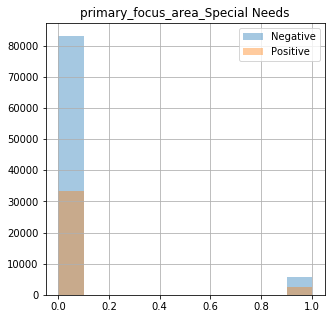

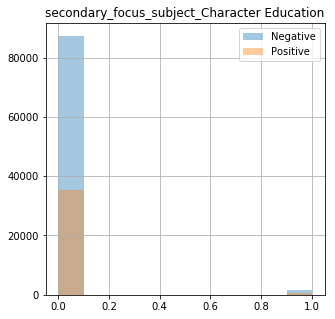

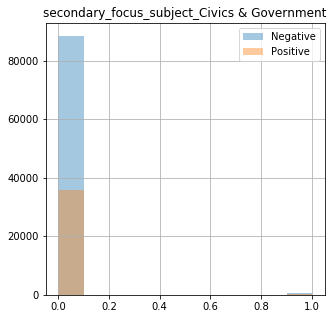

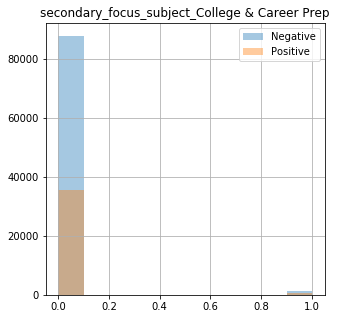

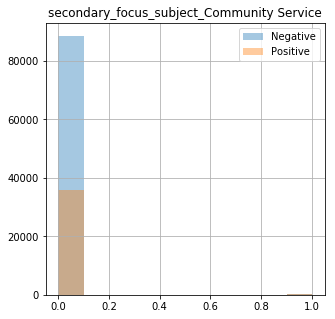

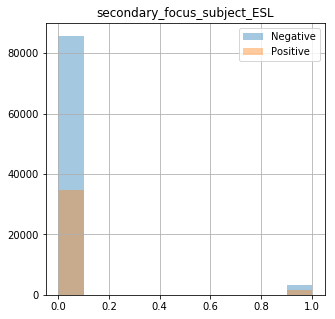

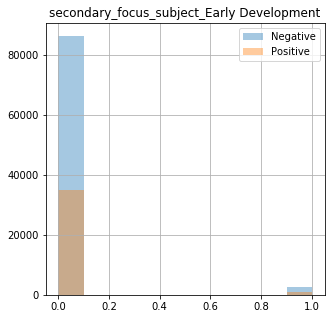

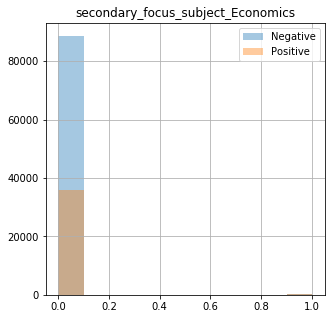

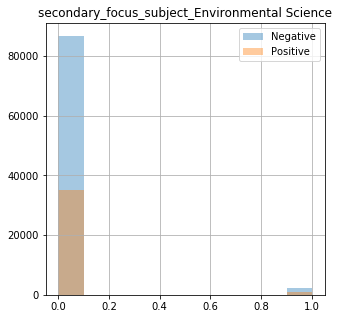

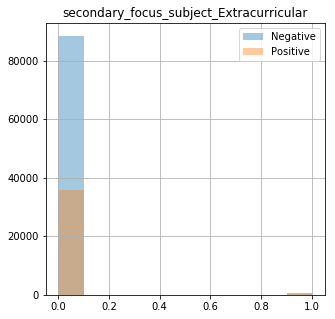

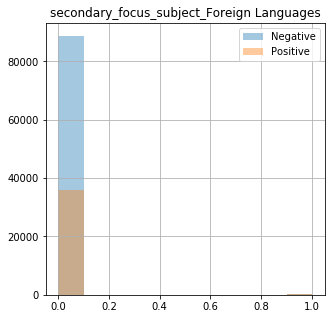

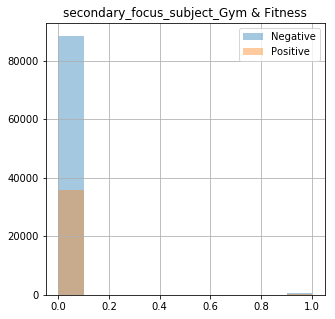

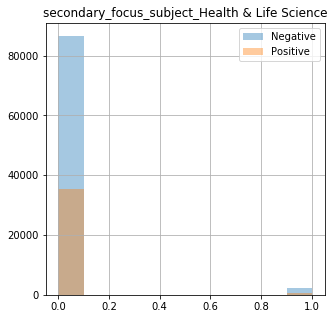

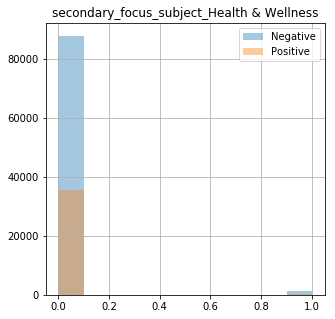

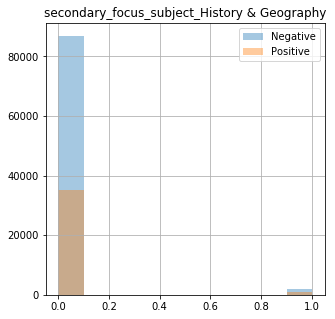

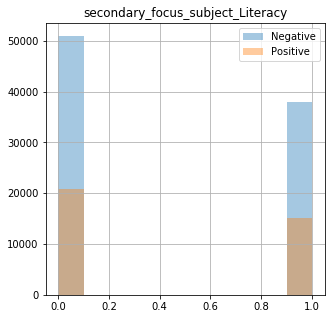

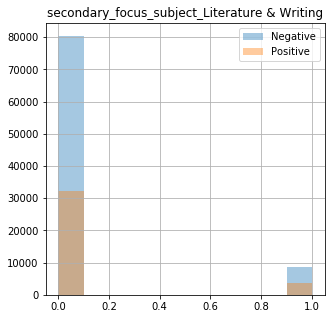

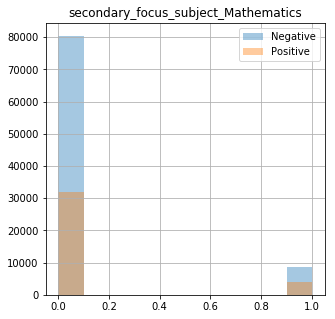

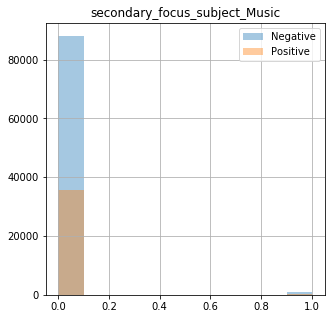

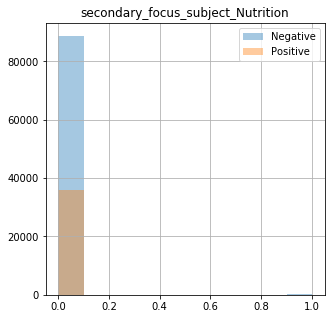

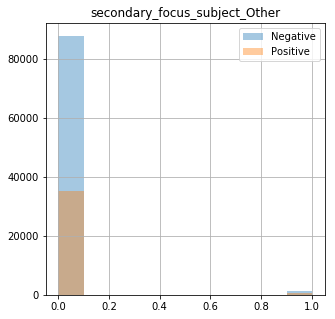

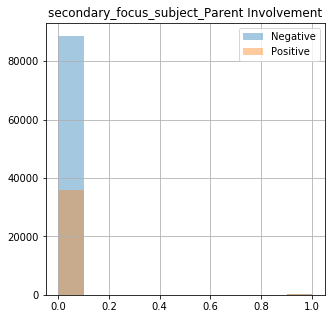

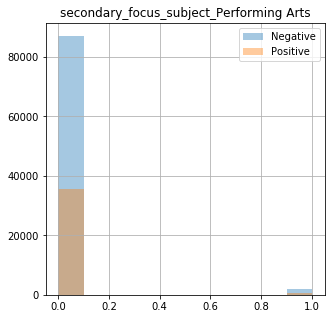

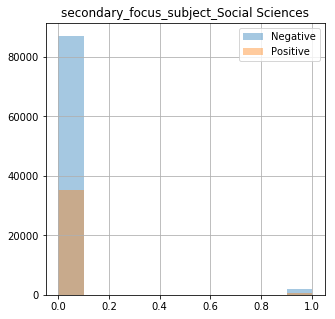

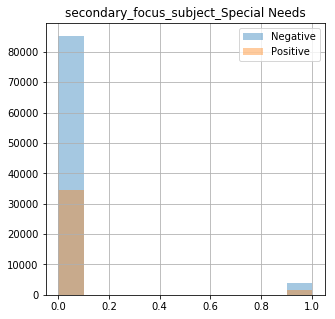

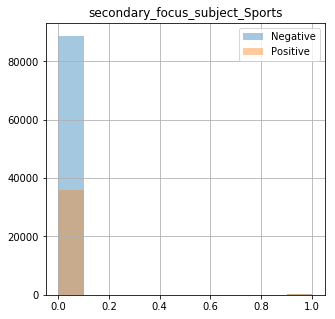

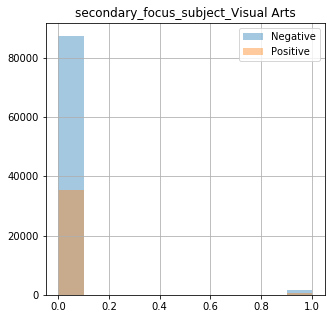

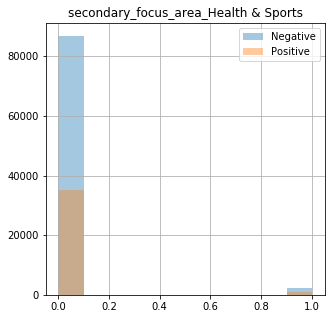

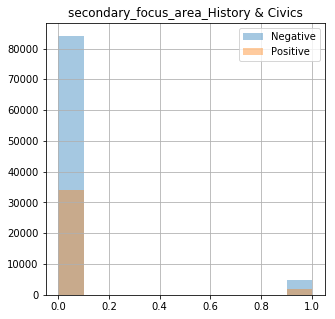

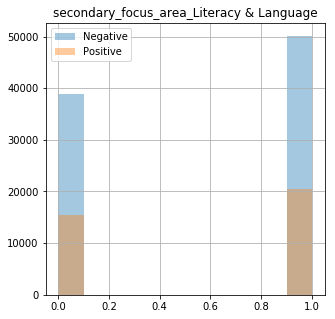

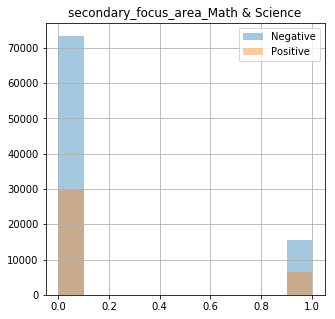

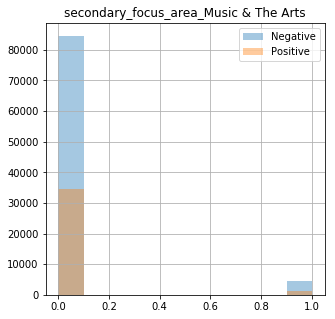

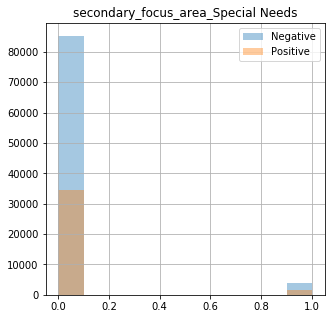

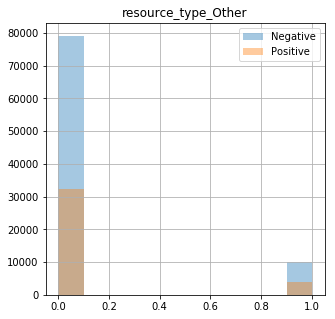

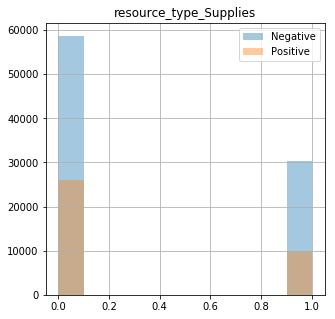

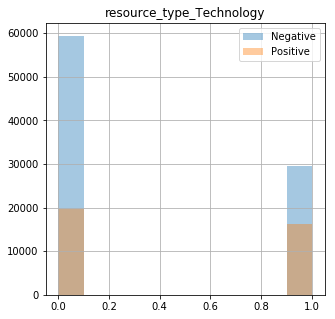

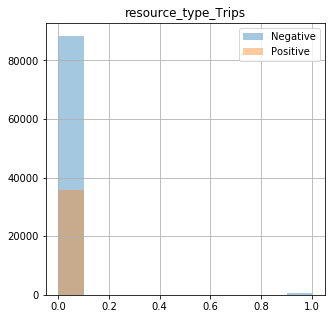

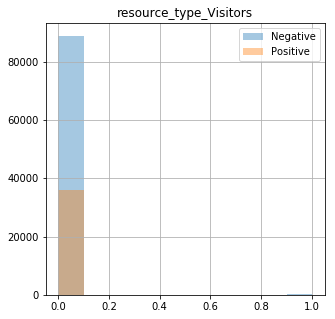

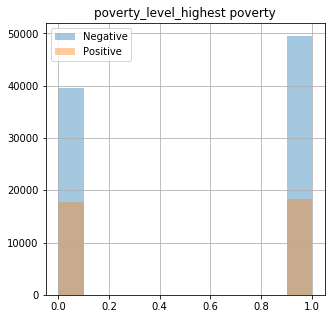

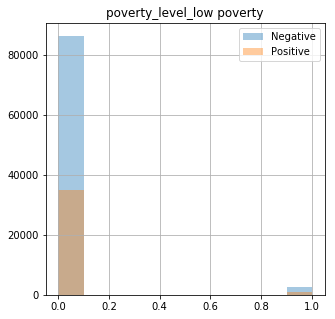

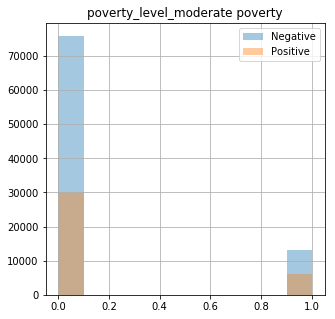

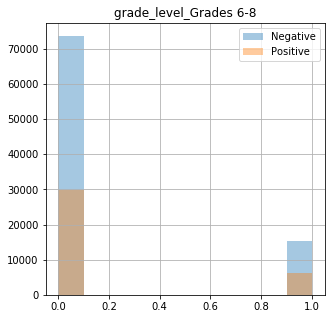

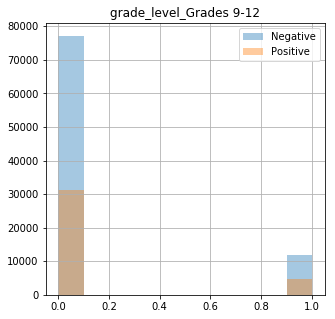

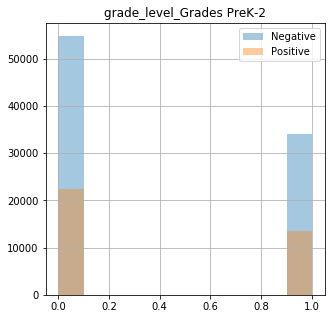

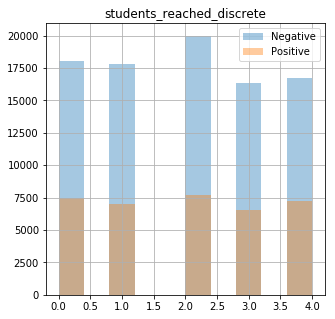

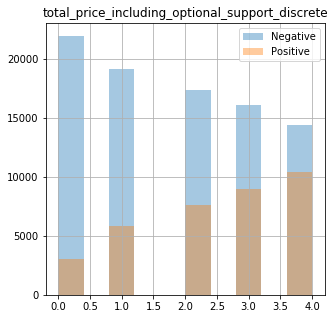

In [48]:
pl.crosshist(reduced_df, 'fundedin60')

### Part 3: Building Models

First we find what dates at which to split our data into training and test sets.
We want our test set to be a rolling window of 6 months, which will give us three test sets. The training sets are everything from 1/1/12 to the beginning of that respective test set.

In [49]:
splits = pl.temporal_validate('2012-01-01', '2013-12-31', [6])
splits

[[datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2012, 6, 30, 0, 0),
  datetime.datetime(2012, 7, 1, 0, 0),
  datetime.datetime(2012, 12, 31, 0, 0)],
 [datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2012, 12, 31, 0, 0),
  datetime.datetime(2013, 1, 1, 0, 0),
  datetime.datetime(2013, 6, 30, 0, 0)],
 [datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2013, 6, 30, 0, 0),
  datetime.datetime(2013, 7, 1, 0, 0),
  datetime.datetime(2013, 12, 31, 0, 0)]]

We then prepare a list of the classifiers we want to test, and the different parameters we want to try out for each classifier. These are: Logistic Regressions, K-Nearest Neighbors, Decision Trees, Support Vector Machines, Random Forests, Boosting, and Bagging.

In [50]:
classifiers = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
               'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
               'LR': LogisticRegression(penalty='l1', C=1e5),
               'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
               'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
               'DT': DecisionTreeClassifier(),
               'KNN': KNeighborsClassifier(n_neighbors=3),
               'BG': BaggingClassifier(LogisticRegression(penalty='l1', C=1e5), n_estimators=10)}

In [51]:
parameters = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000]},
    'GB': {'n_estimators': [10,100], 'learning_rate' : [0.001,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [5,50]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']},
    'BG': {'n_estimators' : [10, 25], 'max_samples' : [.25, .5, 1.0]}
           }

In [52]:
models_to_run = ['RF', 'AB', 'DT', 'GB', 'SVM', 'KNN', 'LR', 'BG']

In [53]:
reduced_df.drop("datefullyfunded", axis = 1, inplace=True)
reduced_df.dtypes

school_charter                                              int64
school_magnet                                               int64
eligible_double_your_impact_match                           int64
date_posted                                        datetime64[ns]
days_to_funded                                              int64
fundedin60                                                  int64
school_metro_suburban                                       uint8
school_metro_urban                                          uint8
teacher_prefix_Mr.                                          uint8
teacher_prefix_Mrs.                                         uint8
teacher_prefix_Ms.                                          uint8
primary_focus_subject_Character Education                   uint8
primary_focus_subject_Civics & Government                   uint8
primary_focus_subject_College & Career Prep                 uint8
primary_focus_subject_Community Service                     uint8
primary_fo

We now loop through all possible models and parameters and run each of them, writing the results to a dataframe.

In [54]:
models, final_params = pl.magic_loop(models_to_run, classifiers, parameters, reduced_df, 'fundedin60', splits, 'date_posted')

[datetime.datetime(2012, 1, 1, 0, 0), datetime.datetime(2012, 6, 30, 0, 0), datetime.datetime(2012, 7, 1, 0, 0), datetime.datetime(2012, 12, 31, 0, 0)]
Current model: RF
{'max_features': 'sqrt', 'n_jobs': -1, 'n_estimators': 10, 'min_samples_split': 2, 'max_depth': 5}
{'max_features': 'sqrt', 'n_jobs': -1, 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5}
{'max_features': 'sqrt', 'n_jobs': -1, 'n_estimators': 10, 'min_samples_split': 10, 'max_depth': 5}
{'max_features': 'sqrt', 'n_jobs': -1, 'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 5}
{'max_features': 'log2', 'n_jobs': -1, 'n_estimators': 10, 'min_samples_split': 2, 'max_depth': 5}
{'max_features': 'log2', 'n_jobs': -1, 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5}
{'max_features': 'log2', 'n_jobs': -1, 'n_estimators': 10, 'min_samples_split': 10, 'max_depth': 5}
{'max_features': 'log2', 'n_jobs': -1, 'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 5}
{'max_features': 'sqrt', 'n_jo

{'weights': 'uniform', 'algorithm': 'auto', 'n_neighbors': 25}
{'weights': 'distance', 'algorithm': 'auto', 'n_neighbors': 25}
{'weights': 'uniform', 'algorithm': 'auto', 'n_neighbors': 50}
{'weights': 'distance', 'algorithm': 'auto', 'n_neighbors': 50}
{'weights': 'uniform', 'algorithm': 'auto', 'n_neighbors': 100}
{'weights': 'distance', 'algorithm': 'auto', 'n_neighbors': 100}
{'weights': 'uniform', 'algorithm': 'ball_tree', 'n_neighbors': 5}
{'weights': 'distance', 'algorithm': 'ball_tree', 'n_neighbors': 5}
{'weights': 'uniform', 'algorithm': 'ball_tree', 'n_neighbors': 10}
{'weights': 'distance', 'algorithm': 'ball_tree', 'n_neighbors': 10}
{'weights': 'uniform', 'algorithm': 'ball_tree', 'n_neighbors': 25}
{'weights': 'distance', 'algorithm': 'ball_tree', 'n_neighbors': 25}
{'weights': 'uniform', 'algorithm': 'ball_tree', 'n_neighbors': 50}
{'weights': 'distance', 'algorithm': 'ball_tree', 'n_neighbors': 50}
{'weights': 'uniform', 'algorithm': 'ball_tree', 'n_neighbors': 100}
{'

{'learning_rate': 0.1, 'n_estimators': 10, 'subsample': 0.1, 'max_depth': 5}
{'learning_rate': 0.1, 'n_estimators': 10, 'subsample': 0.5, 'max_depth': 5}
{'learning_rate': 0.1, 'n_estimators': 10, 'subsample': 1.0, 'max_depth': 5}
{'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.1, 'max_depth': 5}
{'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5, 'max_depth': 5}
{'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1.0, 'max_depth': 5}
{'learning_rate': 0.1, 'n_estimators': 10, 'subsample': 0.1, 'max_depth': 50}
{'learning_rate': 0.1, 'n_estimators': 10, 'subsample': 0.5, 'max_depth': 50}
{'learning_rate': 0.1, 'n_estimators': 10, 'subsample': 1.0, 'max_depth': 50}
{'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.1, 'max_depth': 50}
{'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5, 'max_depth': 50}
{'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 1.0, 'max_depth': 50}
{'learning_rate': 0.5, 'n_estimators': 10, 'subsample': 0.1, 'ma

{'min_samples_split': 5, 'criterion': 'gini', 'max_depth': 50}
{'min_samples_split': 10, 'criterion': 'gini', 'max_depth': 50}
{'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 100}
{'min_samples_split': 5, 'criterion': 'gini', 'max_depth': 100}
{'min_samples_split': 10, 'criterion': 'gini', 'max_depth': 100}
{'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 1}
{'min_samples_split': 5, 'criterion': 'entropy', 'max_depth': 1}
{'min_samples_split': 10, 'criterion': 'entropy', 'max_depth': 1}
{'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 10}
{'min_samples_split': 5, 'criterion': 'entropy', 'max_depth': 10}
{'min_samples_split': 10, 'criterion': 'entropy', 'max_depth': 10}
{'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 20}
{'min_samples_split': 5, 'criterion': 'entropy', 'max_depth': 20}
{'min_samples_split': 10, 'criterion': 'entropy', 'max_depth': 20}
{'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 50}
{'min_samples_split'

### Part 4: Evaluating models

We now look at the models' performance on different metrics. All of these are explained in more detail in the accompanying writeup.

In [55]:
models.head()

,train_start,train_end,test_start,test_end,model_type,clf,parameters,auc-roc,p_at_1,p_at_2,...,r_at_20,r_at_30,r_at_50,f1_at_1,f1_at_2,f1_at_5,f1_at_10,f1_at_20,f1_at_30,f1_at_50
0,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_features': 'sqrt', 'n_jobs': -1, 'n_esti...",0.499365,1,1,...,0.778357,1,1,0.0748431,0.144287,0.32566,0.560239,0.875367,0.922682,0.67887
1,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_features': 'sqrt', 'n_jobs': -1, 'n_esti...",0.501317,1,1,...,0.778357,1,1,0.0748431,0.144287,0.32566,0.560239,0.875367,0.922682,0.67887
2,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_features': 'sqrt', 'n_jobs': -1, 'n_esti...",0.502737,1,1,...,0.778357,0.99514,0.99917,0.0748431,0.144287,0.32566,0.560239,0.875367,0.918198,0.678307
3,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_features': 'sqrt', 'n_jobs': -1, 'n_esti...",0.500466,1,1,...,0.778357,1,1,0.0748431,0.144287,0.32566,0.560239,0.875367,0.922682,0.67887
4,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_features': 'log2', 'n_jobs': -1, 'n_esti...",0.501709,1,1,...,0.778357,0.999881,1,0.0748431,0.144287,0.32566,0.560239,0.875367,0.922572,0.67887


In [56]:
num_cols = [col for col in models.columns if col not in ['train_start', 'train_end', 'test_start', 'test_end', 'model_type', 'clf', 'parameters']]
num_cols

['auc-roc',
 'p_at_1',
 'p_at_2',
 'p_at_5',
 'p_at_10',
 'p_at_20',
 'p_at_30',
 'p_at_50',
 'r_at_1',
 'r_at_2',
 'r_at_5',
 'r_at_10',
 'r_at_20',
 'r_at_30',
 'r_at_50',
 'f1_at_1',
 'f1_at_2',
 'f1_at_5',
 'f1_at_10',
 'f1_at_20',
 'f1_at_30',
 'f1_at_50']

In [57]:
for col in num_cols:
    models[col] = pd.to_numeric(models[col], errors='coerce')

We split the results dataframe into baseline models (which only count the number of positive outcomes in the dataset - this is the accuracy we would get if a naive classifier simply predicted every observation as positive) and non-baseline models.

We see that the baseline accuracy is 25.7% for the first training dataset, 31.4% for the second, and 28.5% for the third.

In [58]:
models_non_baseline = models[models['model_type'] != 'baseline']

In [60]:
models_baseline = models[models['model_type'] == 'baseline']

In [61]:
models_baseline

,train_start,train_end,test_start,test_end,model_type,clf,parameters,auc-roc,p_at_1,p_at_2,...,r_at_20,r_at_30,r_at_50,f1_at_1,f1_at_2,f1_at_5,f1_at_10,f1_at_20,f1_at_30,f1_at_50
149,2012-01-01,2012-06-30,2012-07-01,2012-12-31,baseline,,,0.256928,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,2012-01-01,2012-12-31,2013-01-01,2013-06-30,baseline,,,0.314941,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449,2012-01-01,2013-06-30,2013-07-01,2013-12-31,baseline,,,0.284647,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
pl.summ_stats(models_non_baseline)

,auc-roc,p_at_1,p_at_2,p_at_5,p_at_10,p_at_20,p_at_30,p_at_50,r_at_1,r_at_2,...,r_at_20,r_at_30,r_at_50,f1_at_1,f1_at_2,f1_at_5,f1_at_10,f1_at_20,f1_at_30,f1_at_50
count,447.000000,447.0,447.0,447.0,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,...,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000
mean,0.500357,1.0,1.0,1.0,0.999999,0.999684,0.934056,0.570947,0.035194,0.070463,...,0.705105,0.983081,0.999870,0.067979,0.131594,0.299468,0.520682,0.825563,0.956304,0.725690
std,0.001995,0.0,0.0,0.0,0.000011,0.003759,0.060171,0.047412,0.002964,0.005868,...,0.058618,0.024983,0.001754,0.005531,0.010239,0.021135,0.032018,0.040361,0.026596,0.038412
min,0.495876,1.0,1.0,1.0,0.999774,0.943507,0.783474,0.511176,0.031627,0.063401,...,0.614004,0.806708,0.968373,0.061315,0.119242,0.273962,0.481912,0.751057,0.826339,0.675330
25%,0.497966,1.0,1.0,1.0,1.000000,1.000000,0.856461,0.513856,0.031627,0.063401,...,0.635040,0.952486,1.000000,0.061315,0.119242,0.273962,0.481912,0.776788,0.922682,0.678870
50%,0.501506,1.0,1.0,1.0,1.000000,1.000000,0.948830,0.569307,0.035078,0.070235,...,0.702593,1.000000,1.000000,0.067778,0.131252,0.298782,0.519896,0.825321,0.973743,0.725552
75%,0.502018,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.629911,0.038876,0.077753,...,0.778357,1.000000,1.000000,0.074843,0.144287,0.325660,0.560239,0.875367,0.975665,0.772939
max,0.505885,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.629911,0.038876,0.077753,...,0.778357,1.000000,1.000000,0.074843,0.144287,0.325660,0.560239,0.875367,0.975665,0.772939


In [63]:
pl.make_percent_table(models_non_baseline, "r_at_20")

,r_at_20,count,percent
0,0.614004,1,0.223714
1,0.635040,148,33.109620
2,0.662902,1,0.223714
3,0.702514,1,0.223714
4,0.702593,147,32.885906
5,0.743392,1,0.223714
6,0.773379,1,0.223714
7,0.778357,147,32.885906


The folowing is for the purposes of the writeup and explained in more detail there.

This is the non-baseline model with the highest AUC-ROC score, and its parameters.

In [64]:
models_non_baseline.loc[models_non_baseline['auc-roc'].idxmax()]

train_start                                  2012-01-01 00:00:00
train_end                                    2012-12-31 00:00:00
test_start                                   2013-01-01 00:00:00
test_end                                     2013-06-30 00:00:00
model_type                                                    RF
clf            (DecisionTreeClassifier(class_weight=None, cri...
parameters     {'max_features': 'sqrt', 'n_jobs': -1, 'n_esti...
auc-roc                                                 0.505885
p_at_1                                                         1
p_at_2                                                         1
p_at_5                                                         1
p_at_10                                                        1
p_at_20                                                        1
p_at_30                                                        1
p_at_50                                                 0.629911
r_at_1                   

In [65]:
final_params[159]

{'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 10,
 'n_jobs': -1}

This is the model with the highest F1 score at the 5% threshold, and its parameters.

In [66]:
models_non_baseline.loc[models_non_baseline['f1_at_5'].idxmax()]

train_start                                  2012-01-01 00:00:00
train_end                                    2012-06-30 00:00:00
test_start                                   2012-07-01 00:00:00
test_end                                     2012-12-31 00:00:00
model_type                                                    RF
clf            (DecisionTreeClassifier(class_weight=None, cri...
parameters     {'max_features': 'sqrt', 'n_jobs': -1, 'n_esti...
auc-roc                                                 0.499365
p_at_1                                                         1
p_at_2                                                         1
p_at_5                                                         1
p_at_10                                                        1
p_at_20                                                        1
p_at_30                                                 0.856461
p_at_50                                                 0.513856
r_at_1                   

In [67]:
final_params[0]

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 10,
 'n_jobs': -1}

In [68]:
X_train, X_test, y_train, y_test = pl.temporal_split(reduced_df, datetime(2012, 1, 1, 0, 0), 
                                                              datetime(2013, 6, 30, 0, 0), 
                                                              datetime(2013, 7, 1, 0, 0),
                                                              datetime(2013, 12, 31, 0, 0), 
                                                              'date_posted', 'fundedin60')

In [70]:
auc_best = RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_split=10, n_estimators=10, n_jobs=-1)

In [71]:
auc_best.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [72]:
auc_y_pred = auc_best.predict_proba(X_test)[:,1]

In [74]:
best = RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_split=2, n_estimators=10, n_jobs=-1)

In [75]:
best.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [76]:
y_pred = best.predict_proba(X_test)[:,1]

This is the precision-recall curve for the model with the best F1 score at the 5% threshold.

<Figure size 432x288 with 0 Axes>

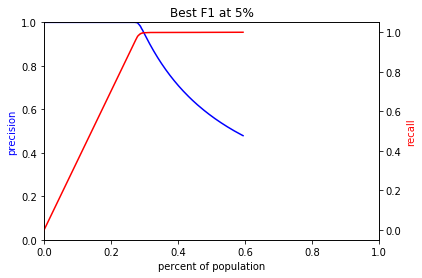

In [102]:
pl.plot_precision_recall_n(y_test, y_pred, "Best F1 at 5%")

The following examines the average performance of each type of classifier, for each timeframe of training data - the last timeframe, then the first, then the second.

In [79]:
models_last = models_non_baseline[models_non_baseline['test_start'] == '2013-07-01']

In [106]:
models_last.groupby('model_type')["p_at_20"].mean()

model_type
AB     1.000000
BG     1.000000
DT     1.000000
GB     1.000000
KNN    1.000000
LR     0.994339
RF     1.000000
SVM    1.000000
Name: p_at_20, dtype: float64

In [105]:
models_last.groupby('model_type')["r_at_20"].mean()

model_type
AB     0.702593
BG     0.702593
DT     0.702593
GB     0.702593
KNN    0.702593
LR     0.698616
RF     0.702593
SVM    0.702593
Name: r_at_20, dtype: float64

In [83]:
models_last.groupby('model_type')["auc-roc"].mean()

model_type
AB     0.497966
BG     0.496644
DT     0.497966
GB     0.497966
KNN    0.497966
LR     0.496720
RF     0.499040
SVM    0.497179
Name: auc-roc, dtype: float64

In [84]:
models_first = models_non_baseline[models_non_baseline['test_start'] == '2012-07-01']

In [100]:
models_first.groupby('model_type')["r_at_10"].mean()

model_type
AB     0.389119
BG     0.389119
DT     0.389119
GB     0.389119
KNN    0.389119
LR     0.389119
RF     0.389119
SVM    0.389119
Name: r_at_10, dtype: float64

In [86]:
models_first.groupby('model_type')["auc-roc"].mean()

model_type
AB     0.502018
BG     0.499300
DT     0.502018
GB     0.502018
KNN    0.502018
LR     0.500338
RF     0.501008
SVM    0.499001
Name: auc-roc, dtype: float64

In [95]:
models_second = models_non_baseline[models_non_baseline['test_start'] == '2013-01-01']

In [101]:
models_second.groupby('model_type')["r_at_10"].mean()

model_type
AB     0.317446
BG     0.317446
DT     0.317446
GB     0.317446
KNN    0.317446
LR     0.317446
RF     0.317446
SVM    0.317446
Name: r_at_10, dtype: float64

In [97]:
models_second.groupby('model_type')["auc-roc"].mean()

model_type
AB     0.501506
BG     0.503481
DT     0.501506
GB     0.501506
KNN    0.501506
LR     0.503621
RF     0.500333
SVM    0.502215
Name: auc-roc, dtype: float64